If you plan on using this implementation, please cite our work:

@INPROCEEDINGS{Grabowski2021IGARSS,
author={Grabowski, Bartosz and Ziaja, Maciej and Kawulok, Michal
and Nalepa, Jakub},
booktitle={IGARSS 2021 - 2021 IEEE International Geoscience
and Remote Sensing Symposium},
title={Towards Robust Cloud Detection in
Satellite Images Using U-Nets},
year={2021},
note={in press}}

# Comparison of cloud detection methods on panchromatic data
This document presents the comparison of three different cloud detection methods on example Landsat 8 panchromatic images. The following methods are compared: U-net architecture, thresholding algorithm and clustering.

# U-net architecture

First, we import neccessary libraries.

In [5]:
import numpy as np
from pathlib import Path
from tensorflow import keras

from cloud_detection.models import unet
from cloud_detection.evaluate_L8CCA import evaluate_model
from cloud_detection.losses import (
    JaccardIndexLoss,
    JaccardIndexMetric,
    DiceCoefMetric,
    recall,
    precision,
    specificity,
)

Next, we set the parameters for the experiment.
These parameters are the following:


- dpath - path to the dataset.
- rpath - path to directory where results should be stored.
- mpath - path to trained model weights.
- vids - tuple of IDs of images which should be used to create visualizations. If contains '*' visualizations will be created for all images in the datasets.
- eval_imgs - IDs of images to evaluate.
- batch_size - size of generated batches, only one batch is loaded to memory at a time.
- thr - threshold for determining whether pixels contain the clouds.
- learning_rate - learning rate for training (needed to load the trained model).
- bn_momentum - momentum of the batch normalization layer.
- bands - band(s) to load (in this case, panchromatic band is loaded).
- bands_names - name(s) of the band(s) to load.
- resize - whether to resize image to match GT.
- normalize - whether to normalize the data.
- standardize - whether to standardize the data.

In [6]:
dpath = Path("datasets/clouds/Landsat-Cloud-Cover-Assessment-Validation-Data-Partial")
rpath = Path("artifacts/panch_cloud_detection_demo/")
mpath = "examples/panch_cloud_model_weights/best_weights"
vids = ["*"]
eval_imgs = ["LC81390292014135LGN00", "LC81940222013245LGN00"]
batch_size = 8
thr = 0.5
learning_rate = 0.01
bn_momentum = 0.9
bands = (8,)
bands_names = ("panchromatic",)
resize = True
normalize = True
standardize = False

We create the instance of the untrained U-Net model. Next, we load the trained weights into the model.

In [ ]:
model = unet(input_size=1, bn_momentum=bn_momentum)
model.compile(
    optimizer=keras.optimizers.Adam(lr=learning_rate),
    loss=JaccardIndexLoss(),
    metrics=[
        keras.metrics.binary_crossentropy,
        keras.metrics.binary_accuracy,
        JaccardIndexLoss(),
        JaccardIndexMetric(),
        DiceCoefMetric(),
        recall,
        precision,
        specificity,
    ],
)
model.load_weights(mpath)

We create the directory to store the results of the model evaluation. Next, we evaluate the model using example Landsat 8 images. The following files are created for each image:


- gt.png - image of the ground-truth cloud mask.
- pred.png - image of the model prediction.
- masks.png - visualisation of the model prediction. Yellow color denotes True Positives, red color denotes False Positives and purple color stands for False Negatives.
- unc.png - uncertainty map, where pixels with uncertain prediction scores are marked in yellow (Note: In the case of the tested model, in most cases almost all of the pixels' prediction scores are very low or very high, which means that the map will almost always not include any yellow pixels.).


If the model's prediction Jaccard Index Metric does not exceed 0.6, the following files are also created:


- roc.html - ROC curve.
- prec_recall.html - precision-recall curve.
- activation_hist.html - histogram of the model's activations scores (please note the logarithmic scale).

In [9]:
rpath.mkdir(parents=True, exist_ok=True)
metrics_L8CCA, _ = evaluate_model(
    model=model,
    thr=thr,
    dpath=dpath,
    rpath=rpath / "eval_vis",
    vids=vids,
    batch_size=batch_size,
    bands=bands,
    bands_names=bands_names,
    img_ids=eval_imgs,
    resize=resize,
    normalize=normalize,
    standardize=standardize
)

Processing Barren-LC81390292014135LGN00
Scene prediction took 122.05654859542847 seconds
Average inference time: 122.05654859542847 seconds
Creating visualisation for LC81390292014135LGN00


/home/bgrabowski/Documents/machine-learning/cloud_detection/utils.py:261: UserWarning:

artifacts/panch_cloud_detection_demo/eval_vis/LC81390292014135LGN00/gt.png is a low contrast image

Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Will make insights for LC81390292014135LGN00
thr dist variance: 0.00031485004379845925
thr dist mean: 0.21809102287495089
Optimal thr: 0.99871
Processing Urban-LC81940222013245LGN00
Scene prediction took 135.4200291633606 seconds
Average inference time: 128.73828887939453 seconds
Creating visualisation for LC81940222013245LGN00


/home/bgrabowski/Documents/machine-learning/cloud_detection/utils.py:261: UserWarning:

artifacts/panch_cloud_detection_demo/eval_vis/LC81940222013245LGN00/gt.png is a low contrast image

Lossy conversion from int64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Finally, we process the output metrics to obtain the mean metrics for the model evaluation.

In [10]:
mean_metrics_L8CCA = {}
for key, value in metrics_L8CCA.items():
    mean_metrics_L8CCA[key] = np.mean(list(value.values()))
print(mean_metrics_L8CCA)

{'L8CCA_binary_crossentropy': 1.3964084, 'L8CCA_binary_accuracy': 0.9127327, 'L8CCA_jaccard_index_loss': 0.20931008, 'L8CCA_jaccard_index_metric': 0.79068995, 'L8CCA_dice_coeff_metric': 0.8691373, 'L8CCA_recall': 0.98438203, 'L8CCA_precision': 0.7995982, 'L8CCA_specificity': 0.8915087, 'L8CCA_normalized_mutual_info_score': 0.6823843342159708, 'L8CCA_adjusted_rand_score': 0.7050384008832693}


# Thresholding algorithm

The algorithm works in the following way:

- The threshold `0 <= T <= 1` as well as an input image X are set.
- The minimum (min_X) and maximum (max_X) values of the pixels are extracted from the image X (please note that for panchromatic data, all pixels have only one value). The border, black pixels are excluded from this operation.
- The image threshold T_X is calculated using the following formula: T_X = min_X + (max_X - min_X) * T
- The image threshold T_X is used to classify the pixels. More specifically, all pixels with value greater or equal to T_X are classified as clouds. The rest is classified as non-clouds.

First, we import neccessary libraries.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from PIL import Image
from pathlib import Path
from collections import defaultdict
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from tensorflow.keras.metrics import binary_crossentropy, binary_accuracy

from cloud_detection.scripts.panchromatic_thresholding import ThresholdingClassifier
from cloud_detection import losses
from cloud_detection.utils import (
    open_as_array, load_l8cca_gt, get_metrics_tf
)

Next, we set the parameters for the experiment.
These parameters are the following:


- dpath - path to the dataset.
- rpath - path to directory where results should be stored.
- eval_imgs - types and IDs of images to evaluate.
- thresholds - threshold values to perform panchromatic thresholding.
- metric_fns - non-Tensorflow metric functions to run evaluation of the thresholding. It must be of the form func(labels_true, labels_pred).
- tf_metric_fns - TensorFlow metric functions to run evaluation of the thresholding. It must be of the form func(labels_true, labels_pred).
- band_num - band to load (in this case, panchromatic band is loaded).
- band_name - name of the band to load.
- normalize - whether to normalize the data.
- standardize - whether to standardize the data.

In [2]:
dpath = Path("datasets/clouds/Landsat-Cloud-Cover-Assessment-Validation-Data-Partial")
rpath = Path("artifacts/cloud_thresholding_demo/")
eval_imgs = [["Barren", "LC81390292014135LGN00"],
             ["Urban", "LC81940222013245LGN00"]]
thresholds = [0.1, 0.5]
metric_fns = [normalized_mutual_info_score,
              adjusted_rand_score]
tf_metric_fns = [losses.JaccardIndexLoss(),
                 losses.JaccardIndexMetric(),
                 losses.DiceCoefMetric(),
                 losses.recall,
                 losses.precision,
                 losses.specificity,
                 binary_crossentropy,
                 binary_accuracy]
band_num = 8
band_name = "panchromatic"
normalize = False
standardize = False

We define the function to load the image as well as its ground truth.

In [3]:
def load_data(img_path, band_name, band_num, normalize, standardize):
    # Load gt
    gt = load_l8cca_gt(img_path)
    # Load img
    channel_files = {}
    channel_files[band_name] = list(
        img_path.glob(f"*_B{band_num}.TIF"))[0]
    img = open_as_array(
        channel_files=channel_files,
        channel_names=(band_name,),
        size=gt.shape,
        normalize=normalize,
        standardize=standardize,
        )
    return img, gt

Next, we define the function to get thresholding algorithm prediction given threshold value and image.

In [4]:
def get_thr_pred(thr, img):
    # Create & fit classifier
    thr_classifier = ThresholdingClassifier(thr_prop=thr).fit(img)
    # Predict cloud mask
    mask = thr_classifier.predict(img)
    return mask

We define the function to calculate desired metrics given ground truth and the cloud mask predicted by the algorithm.

In [5]:
def get_metrics(gt, mask, tf_metric_fns, metric_fns, metrics_aggr):
    metrics = get_metrics_tf(
        np.expand_dims(gt, axis=0),
        np.expand_dims(mask, axis=0),
        tf_metric_fns
    )
    for metric_fn in metric_fns:
        metrics[f"{metric_fn.__name__}"] = metric_fn(
            gt.reshape(-1),
            mask.reshape(-1)
        )
    print(metrics)
    for k, v in metrics.items():
        metrics_aggr[k].append(v)
    return metrics_aggr

Lastly, we define the function to make visualisations of the results, and then save them to rpath dir.

In [6]:
def make_vis(img_type, img_name, gt, mask, rpath, thr):
    fig, axs = plt.subplots(1, 2, sharex=True, sharey=True)
    fig.suptitle(f"{img_type}-{img_name}")
    axs[0].imshow(gt[:, :, 0])
    axs[0].set_title("GT")
    axs[1].imshow(mask[:, :, 0])
    axs[1].set_title("pred")
    fig.savefig(
        rpath / f"thr_{int(thr*100)}" /
        f"{img_type}-{img_name}.png")
    plt.close(fig)

The full pipeline as well as the output can be seen below.

In [8]:
rpath.mkdir(parents=True, exist_ok=False)
img_paths = [dpath / id_[0] / id_[1] for id_ in eval_imgs]
for thr in thresholds:
    print("THRESHOLD:", thr)
    (rpath / f"thr_{int(thr*100)}").mkdir(
        exist_ok=False, parents=True
    )
    metrics_aggr = defaultdict(list)
    for img_path in img_paths:
        img_type, img_name = img_path.parent.name, img_path.name
        print(img_type, img_name)
        img, gt = load_data(img_path, band_name, band_num,
                            normalize, standardize)
        mask = get_thr_pred(thr, img)
        metrics_aggr = get_metrics(gt, mask, tf_metric_fns,
                                   metric_fns, metrics_aggr)
        make_vis(img_type, img_name, gt, mask, rpath, thr)
    metrics_mean = {}
    for k, v in metrics_aggr.items():
        metrics_mean[k] = np.mean(v)
    print("Mean metrics")
    print(metrics_mean)
    print("")

THRESHOLD: 0.1
Barren LC81390292014135LGN00
{'jaccard_index_loss': 0.36021274, 'jaccard_index_metric': 0.63978726, 'dice_coeff_metric': 0.78032964, 'recall': 0.9993018, 'precision': 0.6400734, 'specificity': 0.8138325, 'binary_crossentropy': 2.232164, 'binary_accuracy': 0.8599875, 'normalized_mutual_info_score': 0.49730337919424217, 'adjusted_rand_score': 0.5122466294361192}
Urban LC81940222013245LGN00
{'jaccard_index_loss': 0.005342722, 'jaccard_index_metric': 0.9946573, 'dice_coeff_metric': 0.9973215, 'recall': 0.9957262, 'precision': 0.9989219, 'specificity': 0.99823105, 'binary_crossentropy': 0.053509492, 'binary_accuracy': 0.99667287, 'normalized_mutual_info_score': 0.967493076861695, 'adjusted_rand_score': 0.9866899985758123}
Mean metrics
{'jaccard_index_loss': 0.18277773, 'jaccard_index_metric': 0.81722224, 'dice_coeff_metric': 0.88882554, 'recall': 0.997514, 'precision': 0.81949764, 'specificity': 0.9060318, 'binary_crossentropy': 1.1428367, 'binary_accuracy': 0.9283302, 'norma

The generated images are displayed below.

THRESHOLD: 0.1


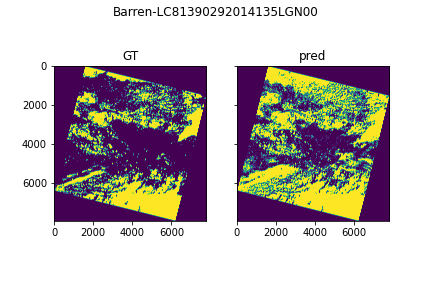

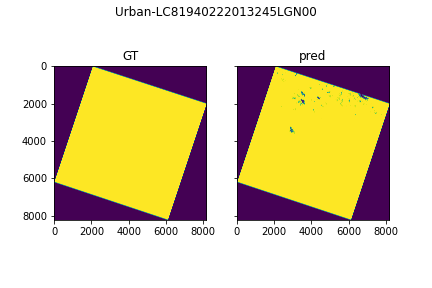

THRESHOLD: 0.5


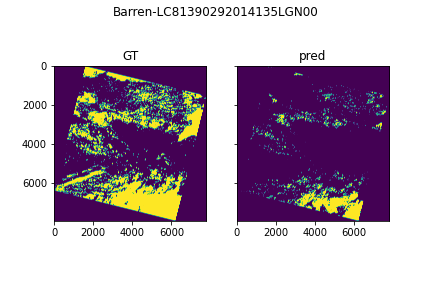

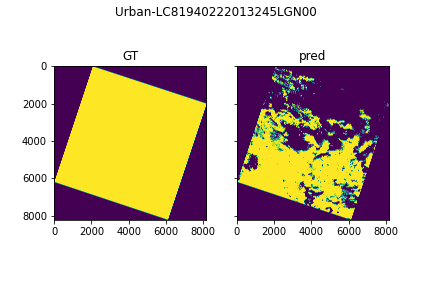

In [9]:
for thr in thresholds:
    print("THRESHOLD:", thr)
    for img_type, img_name in eval_imgs:
        display(Image.open(rpath / f"thr_{int(thr*100)}" / f"{img_type}-{img_name}.png", "r"))

# Clustering

At first import all necessary libraries.

In [12]:
import json
import os
from pathlib import Path

import PIL
import numpy as np
import spectral.io.envi as envi
from IPython.display import display
from PIL import Image
from skimage import img_as_ubyte
from skimage.color import label2rgb
from skimage.io import imsave
from tensorflow.keras.preprocessing.image import load_img

from cloud_detection.scripts.cluster import CLUSTERS, METRICS, BACKGROUND_LABEL
# It is necessary for such large images to change the max pixel setting in PIL.
PIL.Image.MAX_IMAGE_PIXELS = 310000000

Now specify the path to the data and ground-truth files. Both should be in the
same `base` directory.
Additionally, we set the name of the clustering algorithm. The possible
options are `km` and `gm` which stand for K-Means and Gaussian Mixture Model,
respectively. And finally, we specify the target value for the
total number of groups.

In [13]:
img_base_path = Path('datasets/clouds/Landsat-Cloud-Cover-Assessment-Validation-Data-Partial/Barren/LC81390292014135LGN00')
dest_path = os.path.join('../examples', 'clustering_results_Barren')
n_clusters = 2
alg = 'km'

Now open and load the data and ground-truth data.

In [14]:
gt = envi.open(list(img_base_path.glob("*_fixedmask.hdr"))[0])
gt = np.array(gt.open_memmap(), dtype=np.int)
gt = np.where(gt > 128, 1, 0)
img = np.array(load_img(list(img_base_path.glob('*_B8.TIF'))[0],
                                color_mode='grayscale',
                                target_size=gt.shape))

mask = np.where(img != BACKGROUND_LABEL)
data = np.expand_dims(img[mask].ravel(), -1)

After the data is loaded, group the samples, predict the cluster labels
and calculate the metrics to validate the quality of
the unsupervised segmentation process. This process might take a while.

In [15]:
y_true = gt[mask].ravel()
y_pred = CLUSTERS[alg](n_clusters, random_state=0).fit_predict(data)
metrics_barren = {key: f(labels_true=y_true, labels_pred=y_pred)
                  for key, f in METRICS.items()}

Save the resulted maps as images to visually verify the clustering performance.

In [16]:
os.makedirs(dest_path, exist_ok=True)
predicted_map = np.full(img.shape, -1)
predicted_map[mask] = y_pred
np.savetxt(os.path.join(dest_path, f'{n_clusters}-predicted-map.txt'),
           predicted_map, fmt='%i')
imsave(os.path.join(dest_path, f'{n_clusters}-predicted-map.png'),
       img_as_ubyte(label2rgb(predicted_map)))

gt_map = np.full(img.shape, -1)
gt_map[mask] = y_true
np.savetxt(os.path.join(dest_path, f'ground-truth-map.txt'), gt_map, fmt='%i')
imsave(os.path.join(dest_path, f'ground-truth-map.png'),
       img_as_ubyte(label2rgb(gt_map)))

Image.fromarray(img).save(os.path.join(dest_path,'original-map.png'))


Save the metrics to an output file and show them.

In [17]:
with open(os.path.join(dest_path, 'metrics.json'),
          'w') as metrics_file:
    json.dump(metrics_barren, metrics_file, ensure_ascii=False, indent=4)
print(metrics_barren)

{'nmi': 0.477697749935277, 'ars': 0.49989871706213335}


View the images to verify visually the performance of the segmentation.

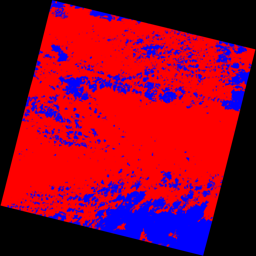

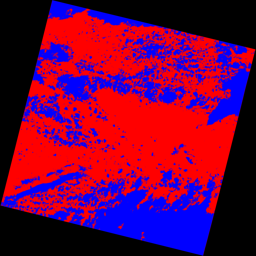

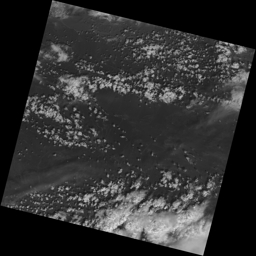

In [18]:

display(Image.open(os.path.join(dest_path, '2-predicted-map.png'),
                   'r').resize((256, 256)))
display(Image.open(os.path.join(dest_path, 'ground-truth-map.png'),
                   'r').resize((256, 256)))
display(Image.open(os.path.join(dest_path, 'original-map.png'),
                   'r').resize((256, 256)))


Run the pipeline for the second image.

ipykernel_launcher:33: UserWarning: ../examples/clustering_results_Urban/ground-truth-map.png is a low contrast image


{'nmi': 2.509850519745815e-05, 'ars': -0.0001958758598669728}


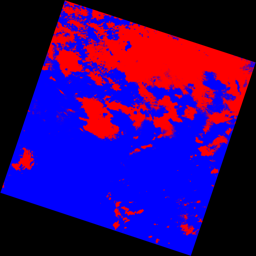

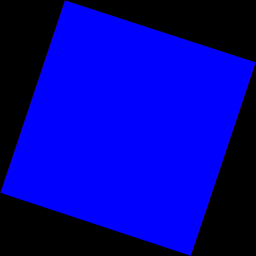

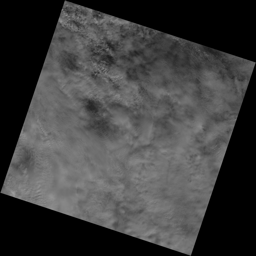

In [19]:
img_base_path = Path('datasets/clouds/Landsat-Cloud-Cover-Assessment-Validation-Data-Partial/Urban/LC81940222013245LGN00')
dest_path = os.path.join('../examples', 'clustering_results_Urban')
n_clusters = 2
alg = 'km'

gt = envi.open(list(img_base_path.glob("*_fixedmask.hdr"))[0])
gt = np.array(gt.open_memmap(), dtype=np.int)
gt = np.where(gt > 128, 1, 0)
img = np.array(load_img(list(img_base_path.glob('*_B8.TIF'))[0],
                                color_mode='grayscale',
                                target_size=gt.shape))

mask = np.where(img != BACKGROUND_LABEL)
data = np.expand_dims(img[mask].ravel(), -1)

y_true = gt[mask].ravel()
y_pred = CLUSTERS[alg](n_clusters, random_state=0).fit_predict(data)
metrics_urban = {key: f(labels_true=y_true, labels_pred=y_pred)
            for key, f in METRICS.items()}

os.makedirs(dest_path, exist_ok=True)
predicted_map = np.full(img.shape, -1)
predicted_map[mask] = y_pred
np.savetxt(os.path.join(dest_path, f'{n_clusters}-predicted-map.txt'),
           predicted_map, fmt='%i')
imsave(os.path.join(dest_path, f'{n_clusters}-predicted-map.png'),
       img_as_ubyte(label2rgb(predicted_map)))

gt_map = np.full(img.shape, -1)
gt_map[mask] = y_true
np.savetxt(os.path.join(dest_path, f'ground-truth-map.txt'), gt_map, fmt='%i')
imsave(os.path.join(dest_path, f'ground-truth-map.png'),
       img_as_ubyte(label2rgb(gt_map)))

Image.fromarray(img).save(os.path.join(dest_path,'original-map.png'))

with open(os.path.join(dest_path, 'metrics.json'),
          'w') as metrics_file:
    json.dump(metrics_urban, metrics_file, ensure_ascii=False, indent=4)
print(metrics_urban)

display(Image.open(os.path.join(dest_path, '2-predicted-map.png'),
                   'r').resize((256, 256)))
display(Image.open(os.path.join(dest_path, 'ground-truth-map.png'),
                   'r').resize((256, 256)))
display(Image.open(os.path.join(dest_path, 'original-map.png'),
                   'r').resize((256, 256)))

Print the mean metrics from both runs.

In [20]:
mean_metrics = {}
for k in metrics_barren.keys():
    mean_metrics[k] = np.mean([metrics_barren[k], metrics_urban[k]])
print(mean_metrics)

{'nmi': 0.23886142422023723, 'ars': 0.2498514206011332}


# Method comparison

The comparison of the methods based on Normalized Mutual Info Score (NMI) and Adjusted Rand Score (ARS) metrics is presented below.

Metrics | U-net | Thr (0.1) | Thr (0.5) | Clustering
--- | --- | --- | --- | ---
NMI | 0.682 | 0.732 | 0.282 | 0.239
ARS | 0.705 | 0.749 | 0.219 | 0.250